In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data
from model_gen import keras_cnn
import tensorflow as tf
import keras
import os
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import keras.backend as K

Using TensorFlow backend.


In [2]:
total_acc_drop = 0.005
# Functions
# x: layer index
# n: total accuracy drop
# s: scale/number of layers
log = lambda x, n, s: n/np.log(s) * np.log(x)
linear = lambda x, n, s: n/s * x
quadratic = lambda x, n, s: n/s**2 * x**2
exponential = lambda x, n, s: n/2**s * 2**x
alloc_types = ['constant', 'log', 'linear', 'quadratic', 'exponential']

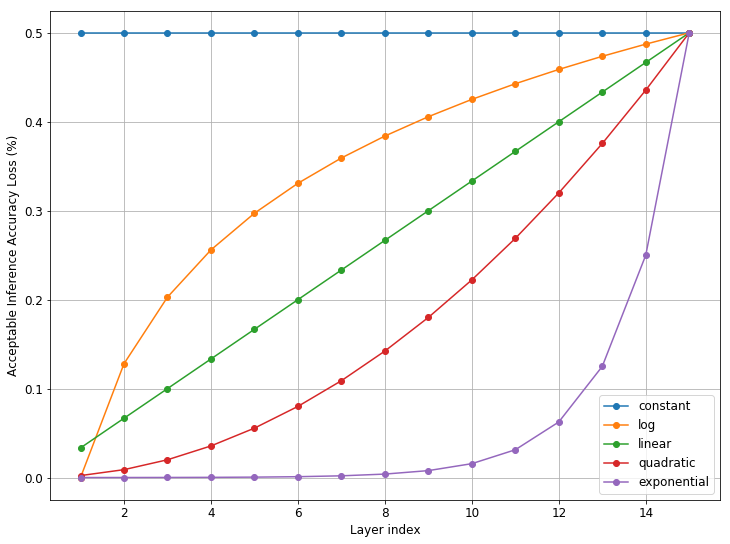

In [3]:
x = np.arange(1, 16, 1)
num_layers = len(x)
n = 0.5 # loss of 0.5%
y1 = np.ones(x.shape) * n # constant
y2 = log(x, n, num_layers) # log
y3 = linear(x, n, num_layers)
y4 = quadratic(x, n, num_layers) # Quadratic
y5 = exponential(x, n, num_layers) # Exponential

plt.rcParams.update({'font.size': 12, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.plot(x, y1, 'o-', label='constant');
plt.plot(x, y2, 'o-', label='log');
plt.plot(x, y3, 'o-', label='linear');
plt.plot(x, y4, 'o-', label='quadratic');
plt.plot(x, y5, 'o-', label='exponential');
plt.grid();
plt.legend();
plt.xlabel('Layer index')
plt.ylabel('Acceptable Inference Accuracy Loss (%)');
plt.savefig('C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Dependent Quantization/ideal_budget_alloc.png',
            bbox_inches='tight')

In [3]:
def get_data_w(path):
    
    with open(path + 'w_scores.p', 'rb') as f:
        w_scores = pickle.load(f)

    with open(path + 'opt_params_w.p', 'rb') as f:
        opt_params_w = pickle.load(f)

    with open(path + 'acc_drop_w.p', 'rb') as f:
        acc_drop_w = pickle.load(f)

    return w_scores, opt_params_w, acc_drop_w

In [4]:
def plot_acc_drop(acc_drop, layer_names, save_path):
    
    plt.rcParams.update({'font.size': 13, 'font.weight':520})
    x = np.arange(1, len(layer_names) + 1, 1)

    plt.figure(figsize=(12, 9))
    for k in alloc_types:
        if not isinstance(acc_drop[k], int):
            arr = np.array(list(acc_drop[k].values())) * 100
            plt.plot(x, arr, 'o-', label=k)

    plt.xlabel('Layers');
    plt.ylabel('Measured Inference Accuracy Loss (%)');
    plt.xticks(x, layer_names, rotation='horizontal');
    plt.grid()
    plt.legend();
    plt.savefig(save_path, bbox_inches='tight')

In [5]:
global_save = 'C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Dependent Quantization/weights/'

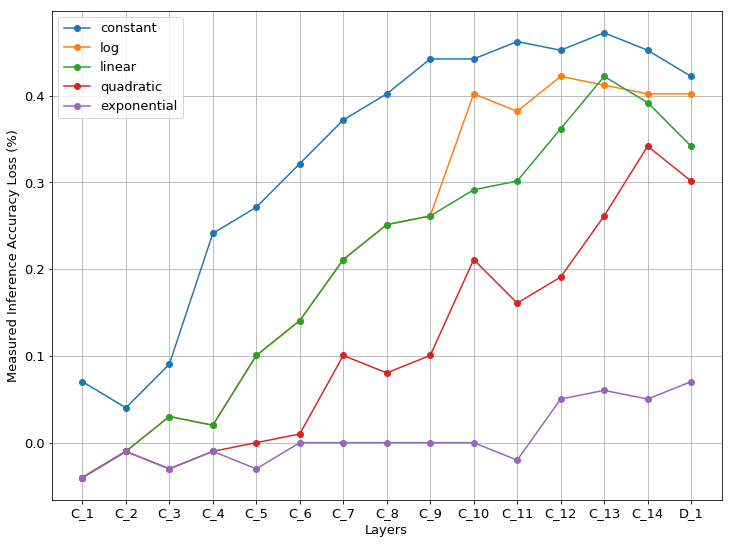

In [13]:
# MNIST
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L MNIST/fixed/'
w_scores, opt_params_w, acc_drop_w = get_data_w(data_path)

layer_names = acc_drop_w['linear'].keys()
layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names ]

save_path = global_save + 'acc_loss/dep_acc_loss_seq_mnist.png'
plot_acc_drop(acc_drop_w, layer_names, save_path)

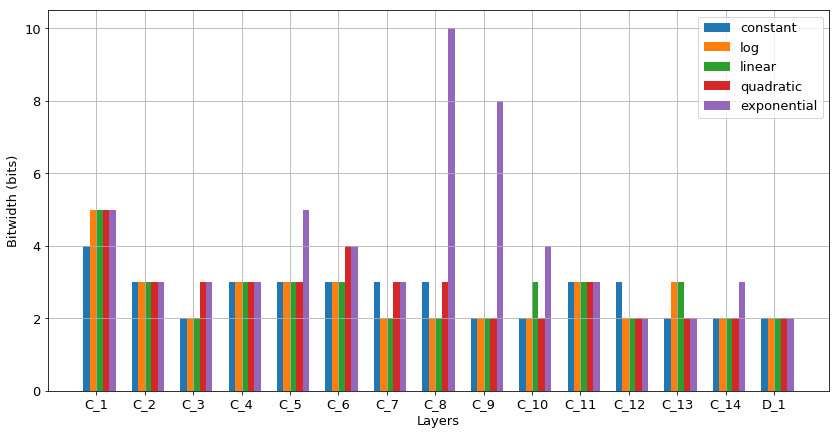

In [15]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth (bits)');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_mnist.png', bbox_inches='tight');

In [83]:
model_path = 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_seq_large.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = []
for layer in model.layers:
    if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        w = layer.get_weights()[0]
        num_weights = len(w.flatten())
        num_params.append(num_weights)

total_memory = {}
for k in alloc_types:
    bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

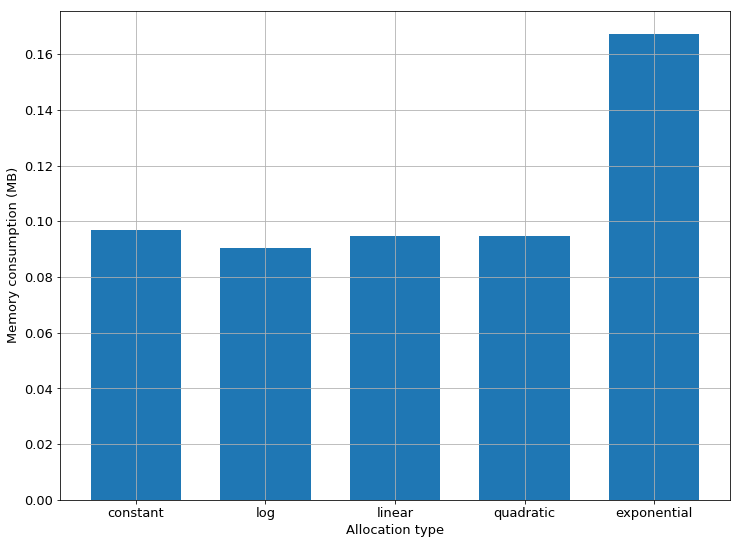

In [84]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), alloc_types, rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_mnist.png', bbox_inches='tight')

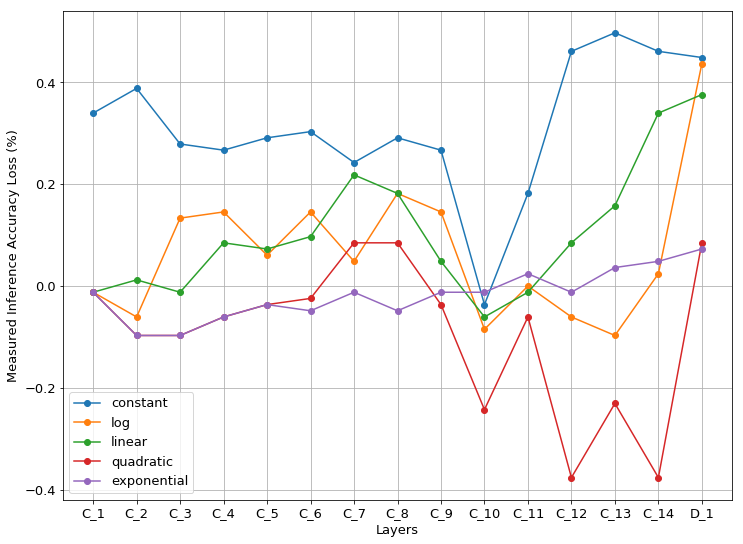

In [16]:
# CIFAR10
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L CIFAR10/fixed/'
w_scores, opt_params_w, acc_drop_w = get_data_w(data_path)

save_path = global_save + 'acc_loss/dep_acc_loss_seq_cifar10.png'
plot_acc_drop(acc_drop_w, layer_names, save_path)

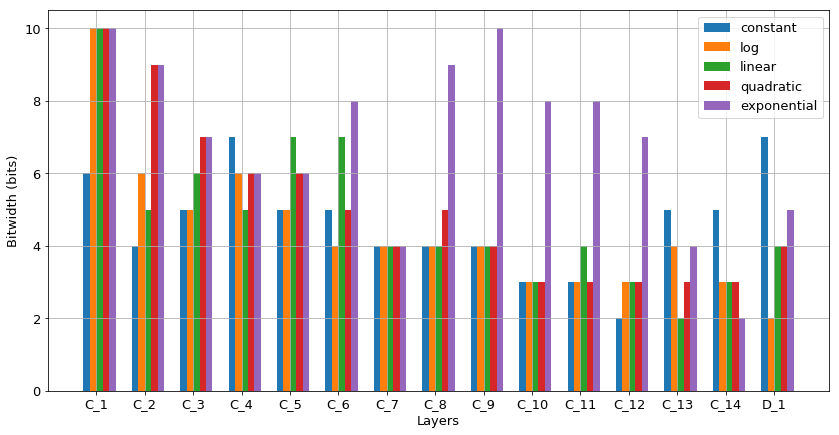

In [17]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth (bits)');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_cifar10.png', bbox_inches='tight');

In [87]:
model_path = 'C:/Users/320060820/experiments/test_models/cifar_keras/cifar_seq_large.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = []
for layer in model.layers:
    if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        w = layer.get_weights()[0]
        num_weights = len(w.flatten())
        num_params.append(num_weights)

total_memory = {}
for k in alloc_types:
    bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

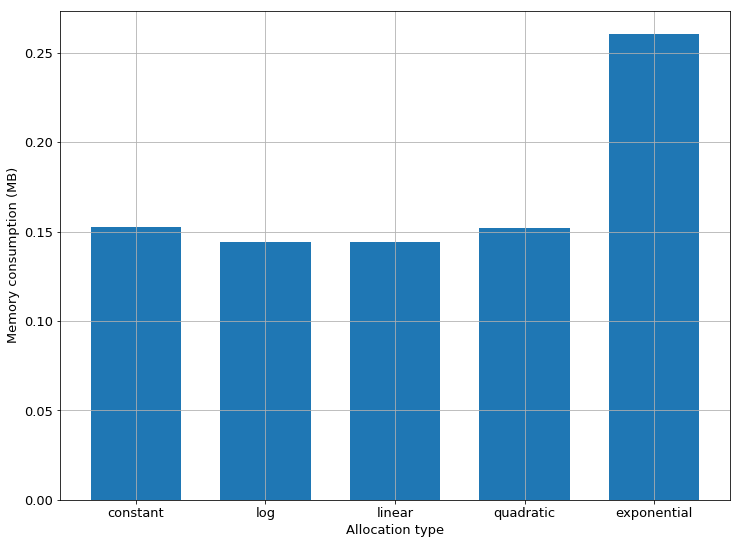

In [88]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), alloc_types, rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_cifar10.png', bbox_inches='tight')

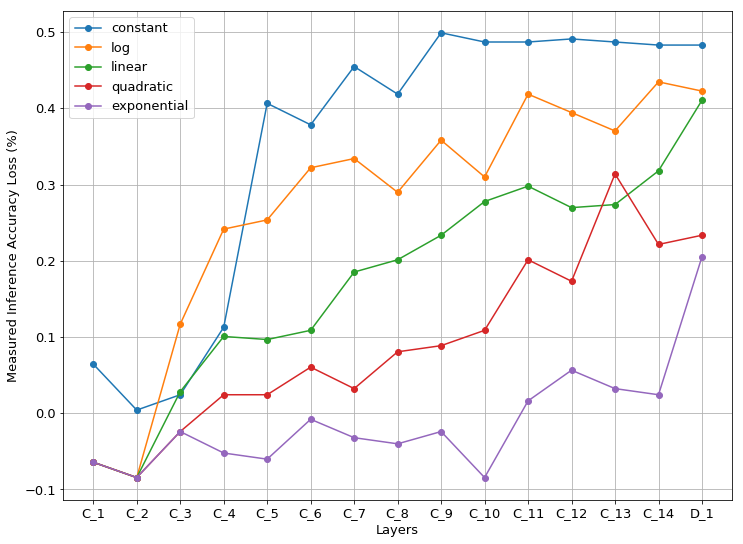

In [18]:
# SVHN
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L SVHN 2/'
w_scores, opt_params_w, acc_drop_w = get_data_w(data_path)

save_path = global_save + 'acc_loss/dep_acc_loss_seq_svhn.png'
plot_acc_drop(acc_drop_w, layer_names, save_path)

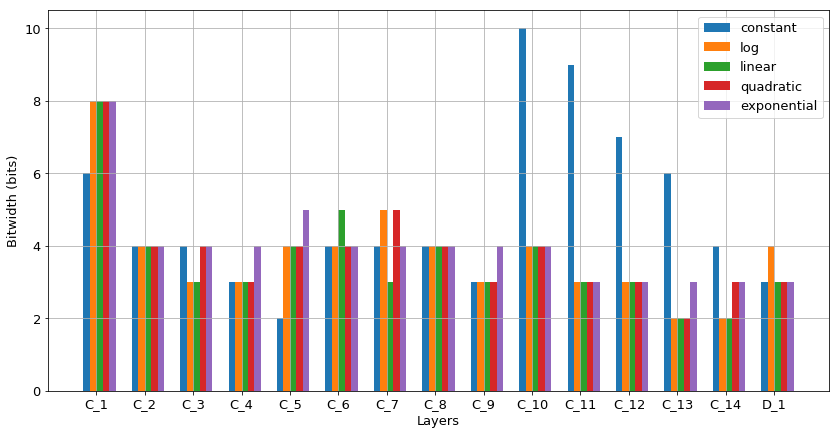

In [19]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth (bits)');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_svhn.png', bbox_inches='tight');

In [91]:
model_path = 'C:/Users/320060820/experiments/test_models/svhn_keras/svhn_seq_large_2.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = []
for layer in model.layers:
    if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        w = layer.get_weights()[0]
        num_weights = len(w.flatten())
        num_params.append(num_weights)

total_memory = {}
for k in alloc_types:
    bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

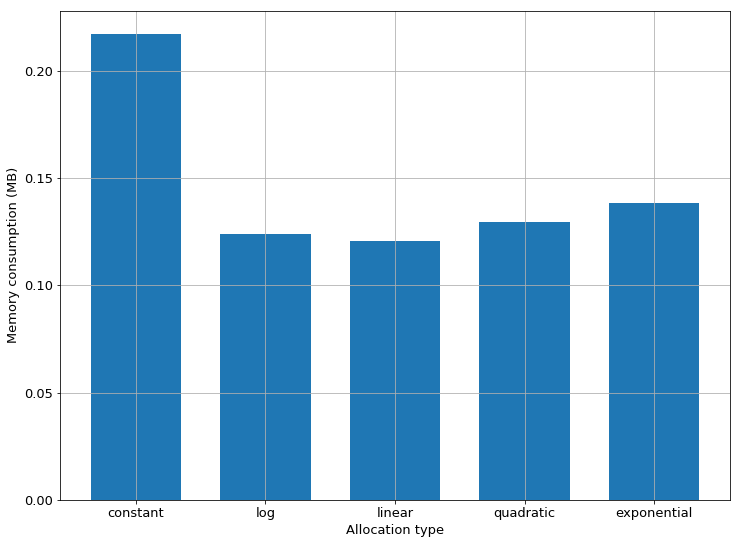

In [92]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), alloc_types, rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_svhn.png', bbox_inches='tight')

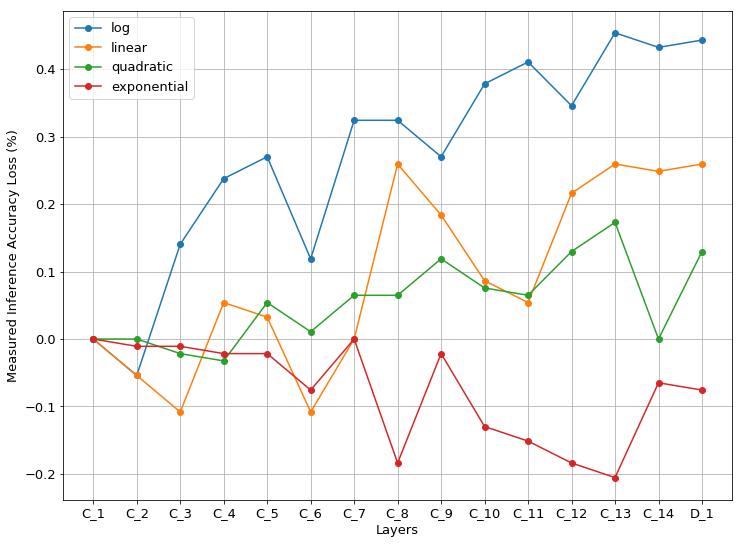

In [20]:
# Fashion
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L Fashion/fixed/'
w_scores, opt_params_w, acc_drop_w = get_data_w(data_path)

save_path = global_save + 'acc_loss/dep_acc_loss_seq_fashion.png'
plot_acc_drop(acc_drop_w, layer_names, save_path)

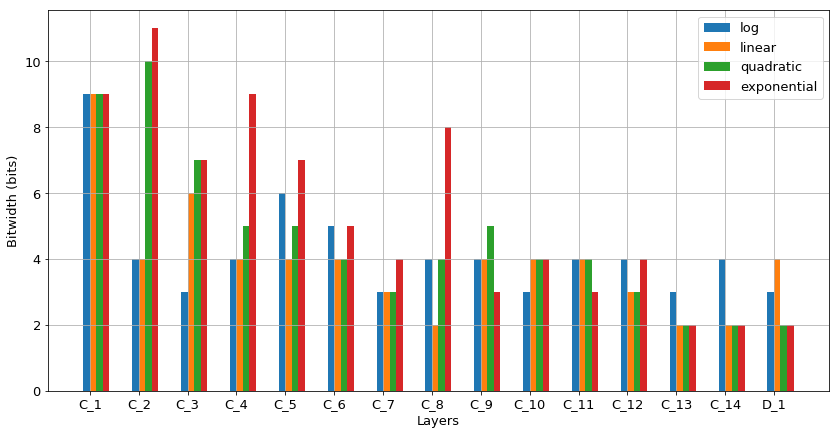

In [21]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    if not isinstance(opt_params_w[k], int):
        bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
        plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth (bits)');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_fashion.png', bbox_inches='tight');

In [95]:
model_path = 'C:/Users/320060820/experiments/test_models/fashion_keras/fashion_seq_large.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = []
for layer in model.layers:
    if layer.weights and layer.name.startswith('conv2d') or layer.name.startswith('dense'):
        w = layer.get_weights()[0]
        num_weights = len(w.flatten())
        num_params.append(num_weights)

total_memory = {}
for k in alloc_types:
    if not isinstance(opt_params_w[k], int):
        bw = [opt_params_w[k][layer][0] for layer in opt_params_w[k]]
        total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

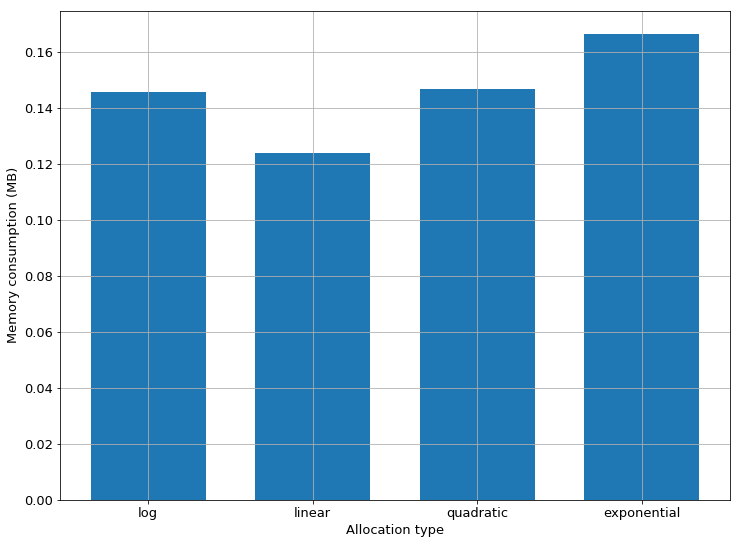

In [96]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), total_memory.keys(), rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_fashion.png', bbox_inches='tight')

### Activations

In [22]:
def get_data_a(path):
    
    with open(path + 'a_scores.p', 'rb') as f:
        w_scores = pickle.load(f)

    with open(path + 'opt_params_a.p', 'rb') as f:
        opt_params_w = pickle.load(f)

    with open(path + 'acc_drop_a.p', 'rb') as f:
        acc_drop_w = pickle.load(f)

    return w_scores, opt_params_w, acc_drop_w

In [23]:
global_save = 'C:/Users/320060820/OneDrive - Philips/Thesis docs/Thesis/Images/Dependent Quantization/activations/'

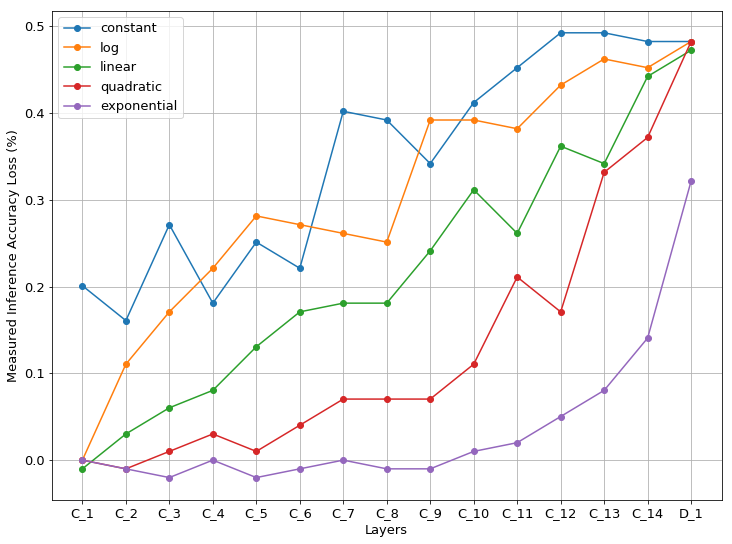

In [24]:
# MNIST
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L MNIST/fixed/'
a_scores, opt_params_a, acc_drop_a = get_data_a(data_path)

layer_names = acc_drop_a['linear'].keys()
layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names ]

save_path = global_save + 'acc_loss/dep_acc_loss_seq_mnist_a.png'
plot_acc_drop(acc_drop_a, layer_names, save_path)

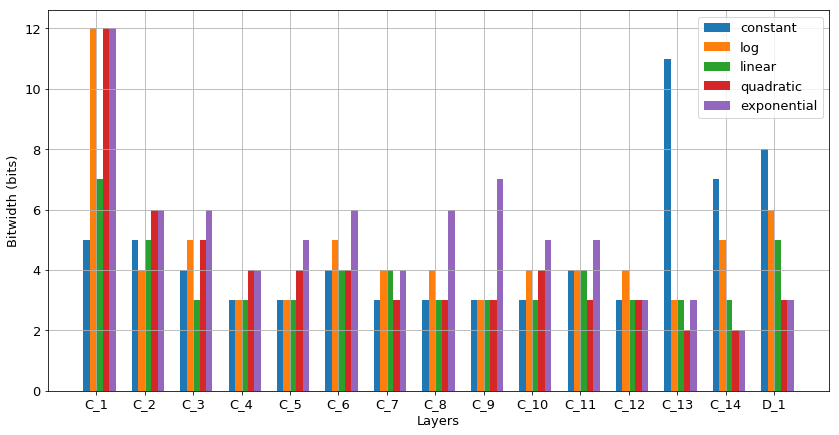

In [25]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth (bits)');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_mnist_a.png', bbox_inches='tight');

In [101]:
model_path = 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_seq_large.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = model_data.get_num_activations_per_layer(model, list(acc_drop_a['linear'].keys()))
print(num_params)
total_memory = {}
for k in alloc_types:
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

[21632, 21632, 21632, 21632, 5408, 5408, 10816, 10816, 3136, 3136, 3136, 3136, 1024, 1024, 10]


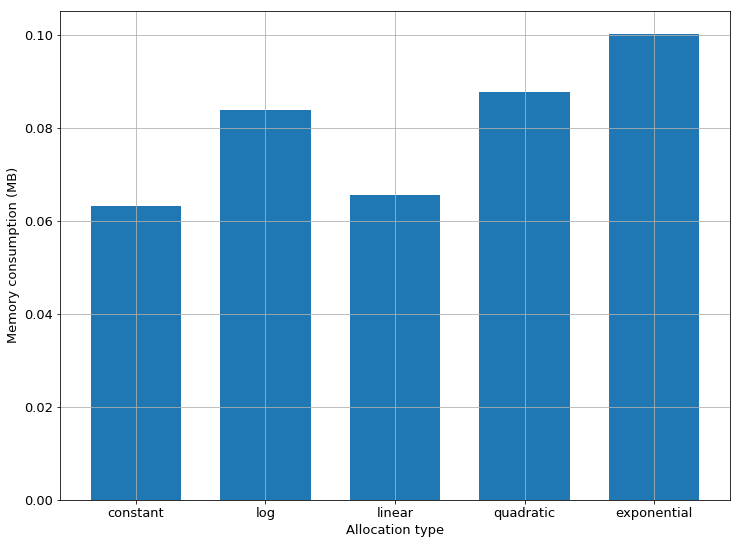

In [102]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), alloc_types, rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_mnist_a.png', bbox_inches='tight')

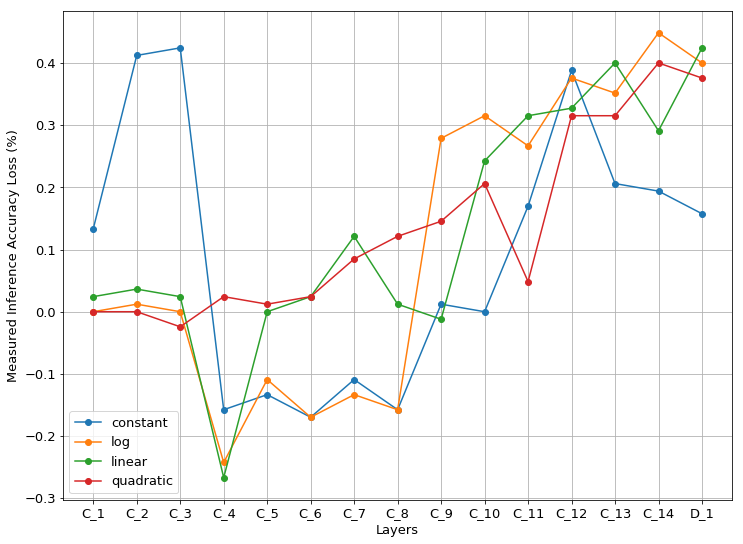

In [26]:
# CIFAR10
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L CIFAR10/fixed/'
a_scores, opt_params_a, acc_drop_a = get_data_a(data_path)

layer_names = acc_drop_a['linear'].keys()
layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names ]

save_path = global_save + 'acc_loss/dep_acc_loss_seq_cifar10_a.png'
plot_acc_drop(acc_drop_a, layer_names, save_path)

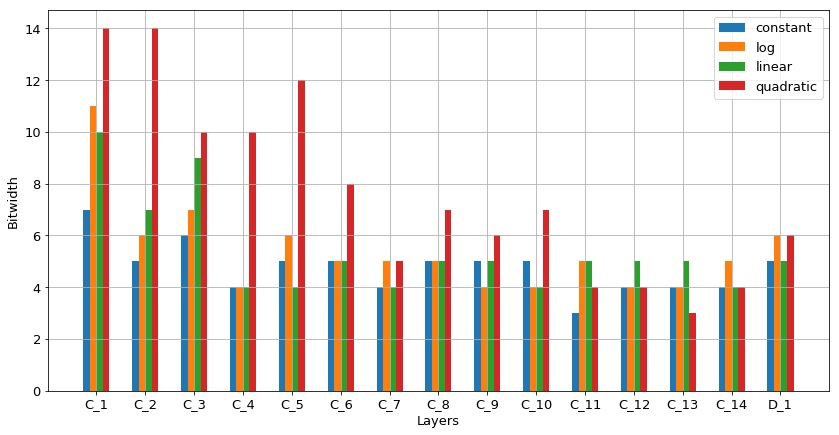

In [27]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    if isinstance(opt_params_a[k], int):
        continue
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_cifar10_a.png', bbox_inches='tight');

In [105]:
model_path = 'C:/Users/320060820/experiments/test_models/cifar_keras/cifar_seq_large.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = model_data.get_num_activations_per_layer(model, list(acc_drop_a['linear'].keys()))
print(num_params)
total_memory = {}
for k in alloc_types:
    if isinstance(opt_params_a[k], int):
        continue
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

[28800, 28800, 28800, 28800, 7200, 7200, 14400, 14400, 4096, 4096, 4096, 4096, 1024, 1024, 10]


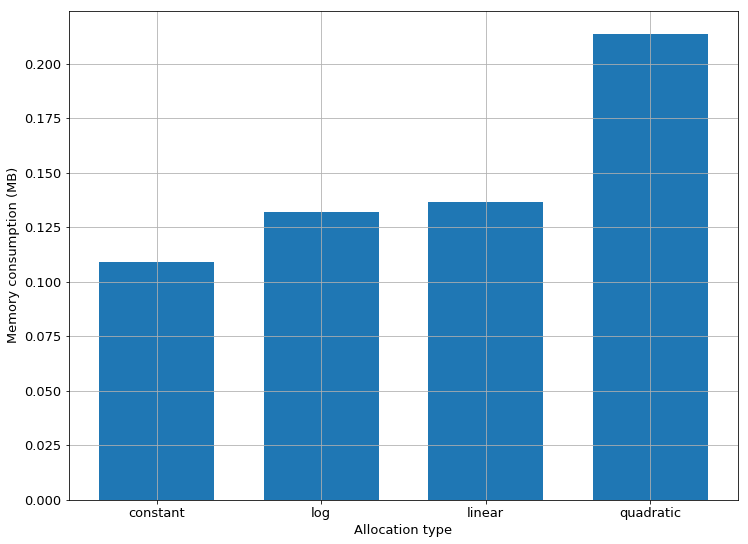

In [106]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), alloc_types, rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_cifar10_a.png', bbox_inches='tight')

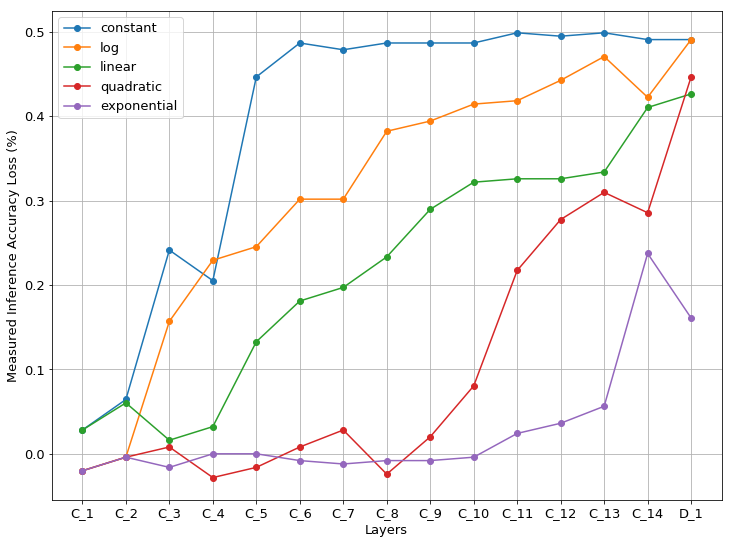

In [28]:
# SVHN
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L SVHN 2/'
a_scores, opt_params_a, acc_drop_a = get_data_a(data_path)

layer_names = acc_drop_a['linear'].keys()
layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names ]

save_path = global_save + 'acc_loss/dep_acc_loss_seq_svhn_a.png'
plot_acc_drop(acc_drop_a, layer_names, save_path)

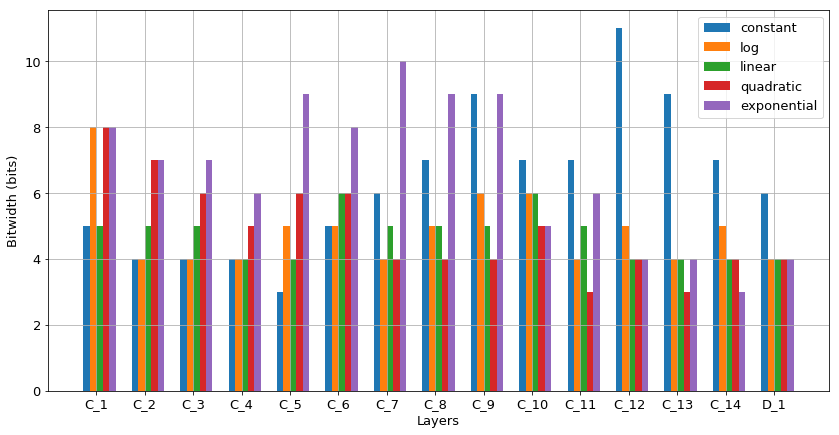

In [29]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth (bits)');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_svhn_a.png', bbox_inches='tight');

In [109]:
model_path = 'C:/Users/320060820/experiments/test_models/svhn_keras/svhn_seq_large_2.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = model_data.get_num_activations_per_layer(model, list(acc_drop_a['linear'].keys()))
print(num_params)
total_memory = {}
for k in alloc_types:
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

[28800, 28800, 28800, 28800, 7200, 7200, 14400, 14400, 4096, 4096, 4096, 4096, 1024, 1024, 10]


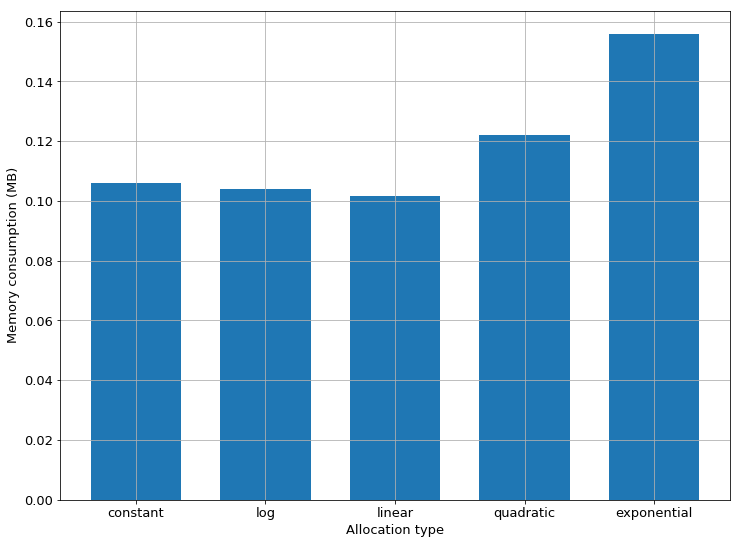

In [110]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), alloc_types, rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_svhn_a.png', bbox_inches='tight')

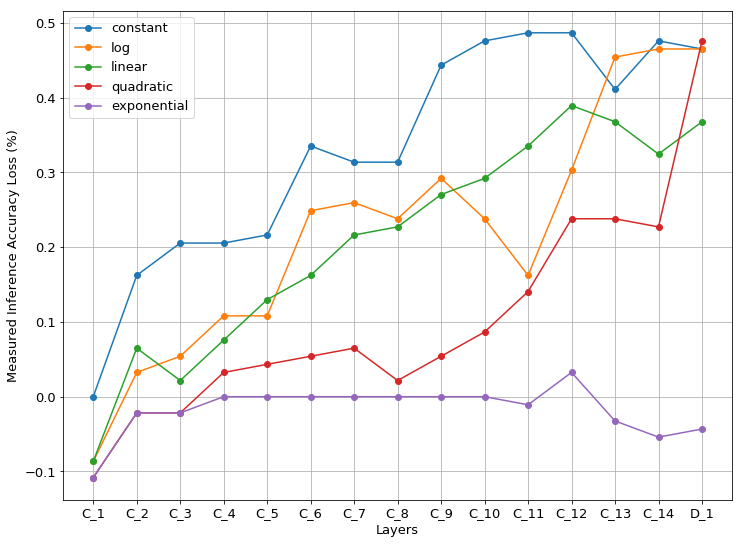

In [30]:
# Fashion
data_path = 'C:/Users/320060820/experiments/outputs/Dependent_Optimized_Search/F Sequential L Fashion/fixed/'
a_scores, opt_params_a, acc_drop_a = get_data_a(data_path)

layer_names = acc_drop_a['linear'].keys()
layer_names = ['C_{}'.format(x.split('_')[1]) if x.startswith('conv') else 'D_1' for x in layer_names ]

save_path = global_save + 'acc_loss/dep_acc_loss_seq_fashion_a.png'
plot_acc_drop(acc_drop_a, layer_names, save_path)

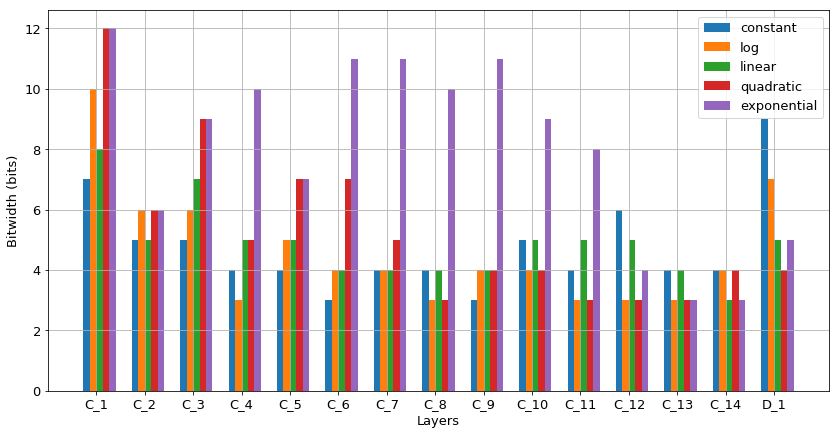

In [31]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(14, 7))
width = 0.4
x = np.arange(1, 3*len(layer_names) + 1, 3)
for j, k in enumerate(alloc_types):
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    plt.bar([i + j*width for i in x], bw, width, label=k)
plt.xticks(x + 1.5*width, layer_names, rotation='horizontal')
plt.xlabel('Layers');
plt.ylabel('Bitwidth (bits)');
plt.grid()
plt.legend();
plt.savefig(global_save + 'bw/dep_bw_seq_fashion_a.png', bbox_inches='tight');

In [113]:
model_path = 'C:/Users/320060820/experiments/test_models/fashion_keras/fashion_seq_large.h5'
K.clear_session()
model = keras.models.load_model(model_path)
num_params = model_data.get_num_activations_per_layer(model, list(acc_drop_a['linear'].keys()))
print(num_params)
total_memory = {}
for k in alloc_types:
    bw = [opt_params_a[k][layer][0] for layer in opt_params_a[k]]
    total_memory[k] = sum([bw[i] * num_params[i] for i in range(len(layer_names))])

memory_consumption = [total_memory[k] for k in total_memory]
memory_consumption_KB = [i/(8*1024**2) for i in memory_consumption]

[21632, 21632, 21632, 21632, 5408, 5408, 10816, 10816, 3136, 3136, 3136, 3136, 1024, 1024, 10]


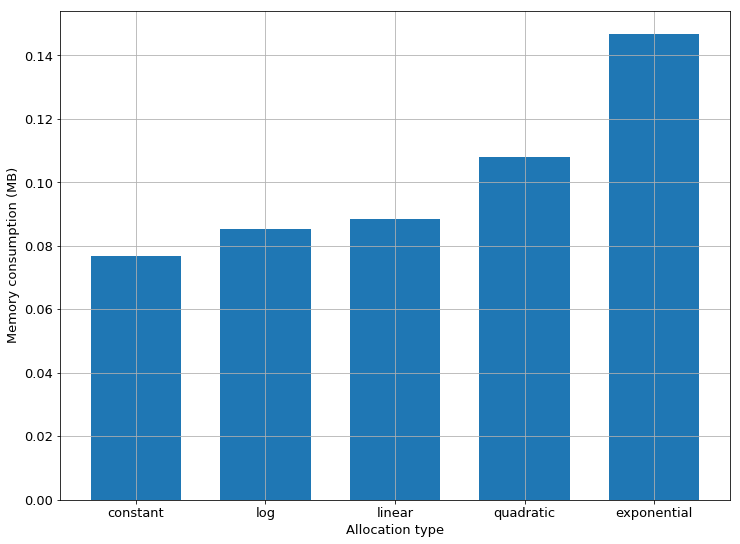

In [114]:
plt.rcParams.update({'font.size': 13, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.bar(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), memory_consumption_KB, width=0.35);
plt.xticks(np.arange(1, len(memory_consumption_KB)/2 + 1, 0.5), alloc_types, rotation='horizontal');
plt.xlabel('Allocation type')
plt.ylabel('Memory consumption (MB)');
plt.grid();
plt.savefig(global_save + 'mem/dep_mem_seq_fashion_a.png', bbox_inches='tight')